<a href="https://colab.research.google.com/github/yuchenhe-xai/yccolab/blob/main/241029_exp_better_user_production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
!pip install polars --index-url https://pypi.org/simple

In [2]:
import ast
import asyncio
import glob
import json
import logging
import os
import re
import traceback
from typing import Any
import pandas as pd

import uuid
from xlm.config import configclass
from xlm.posttrain import utils
from xlm.posttrain.data import formatting
from xlm.posttrain.evals.eval_base import SamplerEvalBase
from xlm.sampling_client import SamplingClient

# Figure out which part of data we trained are user’s happy ?  what user wanted - rubrics , if  we followed their instructions - verifier

In [5]:
import inspect

# sys.path.append(os.path.expanduser('~/xai/train/'))

import xlm
import xlm.reward_client

def display_conversation(conversation, conv_loss_mask=None):
    """
    Display a conversation in a notebook with different colors for the 'user' and 'assistant' roles.

    Parameters:
    - conversation (list of dict): List of dictionaries containing 'role' and 'content'.
    - conv_loss_mask (list of bool): List of boolean values indicating whether to highlight the message.
    """
    from IPython.display import HTML, display

    user_bg_color = "#d0e7ff"  # light blue for user messages
    assistant_bg_color = "#d4edda"  # light green for assistant messages
    user_text_color = "#084298"  # darker blue for user text
    assistant_text_color = "#155724"  # darker green for assistant text
    html_output = ""

    for i, entry in enumerate(conversation):
        role = entry["role"]
        content = entry["content"]
        is_user = role.lower() in ["user", "human"]

        # Set color based on role
        bg_color = user_bg_color if is_user else assistant_bg_color
        text_color = user_text_color if is_user else assistant_text_color
        role_display = "User" if is_user else "Assistant"

        # Highlight if conv_loss_mask is True for this message
        if conv_loss_mask is not None and conv_loss_mask[i]:
            highlight_style = "font-weight: bold; text-decoration: underline;"
        else:
            highlight_style = "font-weight: normal;"

        # Append each entry to HTML string with styling
        html_output += f"""
        <div style='background-color: {bg_color}; color: {text_color};
                    border-radius: 8px; padding: 10px; margin: 8px 0;'>
            <strong style='{highlight_style}'>{role_display}:</strong><br>
            <span style='{highlight_style}'>{content}</span>
        </div>
        """

    display(HTML(html_output))

# Load User production data

In [ ]:
import os
import yaml
import json
import polars as pl
from pathlib import Path

# BP = Path('/xshare')
BP = Path('/data/yuchen/userdata/')
DS = ['xai_user_grok_feedbacks_snapshot', 'xai_user_grok_chats_snapshot', 'xai_user_grok_debug_events_snapshot']

def get_latest(path: Path) -> Path:
  assert path.is_dir(), "not dir: " + str(path)
  return max((d for d in path.iterdir() if d.is_dir()), key=lambda x: x.stat().st_mtime, default=None)

def load_parquets(path: Path) -> pl.DataFrame:
  try:
      path = path / 'part-*.snappy.parquet'
      print(path)
      return pl.read_parquet(path)
  except Exception as e:
      print("ERROR", e, path)
      return None

latest_chunk = get_latest(BP / DS[1]).name
latest_chunk = '2024102623'
print(f'latest chunk: {latest_chunk}')


h = {}
for ds in DS:
  path = BP / ds / latest_chunk
  print(path)
  h[ds] = load_parquets(path)
  print(f'loaded {path}')

latest chunk: 2024102623
/data/yuchen/userdata/xai_user_grok_feedbacks_snapshot/2024102623
/data/yuchen/userdata/xai_user_grok_feedbacks_snapshot/2024102623/part-*.snappy.parquet
loaded /data/yuchen/userdata/xai_user_grok_feedbacks_snapshot/2024102623
/data/yuchen/userdata/xai_user_grok_chats_snapshot/2024102623
/data/yuchen/userdata/xai_user_grok_chats_snapshot/2024102623/part-*.snappy.parquet
loaded /data/yuchen/userdata/xai_user_grok_chats_snapshot/2024102623
/data/yuchen/userdata/xai_user_grok_debug_events_snapshot/2024102623
/data/yuchen/userdata/xai_user_grok_debug_events_snapshot/2024102623/part-*.snappy.parquet
loaded /data/yuchen/userdata/xai_user_grok_debug_events_snapshot/2024102623


In [ ]:
chats_df = h['xai_user_grok_chats_snapshot']
debug_events_df = h['xai_user_grok_debug_events_snapshot']
feedback_df = h['xai_user_grok_feedbacks_snapshot']

print(len(chats_df))
# preprocess
try:
  chats_df = chats_df.drop(['userId', 'queries', 'modelVersion', 'mediaIds', 'postIds'])
except Exception: pass
chats_df = chats_df.rename({"chatId": "conversation_id", "chatItemId": "chat_item_id", 'responseToChatItemId': 'response_to_chat_item_id'})
chats_df = chats_df.with_columns(pl.from_epoch(pl.col('createdAtMsec'), time_unit='ms').alias('timestamp')).drop(['createdAtMsec'])
feedback_df = feedback_df.with_columns(pl.from_epoch(pl.col('createdAtMsec'), time_unit='ms').alias('timestamp')).drop(['createdAtMsec', 'modelVersion', 'feedbackScheme', 'userId'])

# filter on TS
min_dt = pl.datetime(2024, 10, 2)
chats_df = chats_df.filter(pl.col('timestamp') > min_dt)
feedback_df = feedback_df.filter(pl.col('timestamp') > min_dt)
print(f'len(chats_df): {len(chats_df)}, len(feedback_df): {len(feedback_df)}')

chats_df_org = chats_df.clone()

# take disliked conversations
disliked_chat_item_ids = feedback_df.filter(pl.col('feedbackData').struct.field('basicGrokResponseFeedback').struct.field('basicFeedbackType') == 'DISLIKE')['conversationItemId']
disliked_conversation_ids = chats_df.filter(pl.col('chat_item_id').is_in(disliked_chat_item_ids))['conversation_id'].unique()

# sanity check
if debug_events_df is not None:
  t = debug_events_df.filter(pl.col('conversation_id').is_in(disliked_conversation_ids))
  print(f'disliked_conversation_ids: {len(disliked_conversation_ids)}')
  print(f'conversations_with_debug_events: {len(t["conversation_id"].unique())}')

n = 500000
sampled_conversation_ids = debug_events_df['conversation_id'].unique().sample(n=n)
chats_df = chats_df.filter(pl.col('conversation_id').is_in(disliked_conversation_ids) & pl.col('conversation_id').is_in(sampled_conversation_ids)).sort('chat_item_id')
chats_df = chats_df.filter(pl.col('conversation_id').is_in(disliked_conversation_ids)).sort('chat_item_id')
debug_events_df = (debug_events_df
    .filter(pl.col('conversation_id').is_in(chats_df['conversation_id']))
    .group_by("response_to_chat_item_id")
    .agg([
        pl.col("conversation_id").first(),
        pl.col("debug_info")
    ]))

df = chats_df.join(debug_events_df, left_on='chat_item_id', right_on='response_to_chat_item_id', how='left')
df = df.group_by('conversation_id').agg(pl.col('message'), pl.col('sender'), pl.col('debug_info'), pl.col('generatedImageUrls'), pl.col('grokMode'), pl.col('chat_item_id'))
print(f'total conversations: {len(df)}')

len(chats_df): 1198470, len(feedback_df): 432219
disliked_conversation_ids: 1671
conversations_with_debug_events: 1231
total conversations: 206


## Keep Chat group data and save on fer

In [ ]:
order_by_key = 'timestamp'
chats_df_group = (
    chats_df_org
    .group_by('conversation_id')
    .agg([
        pl.col('message').sort_by(order_by_key),
        pl.col('sender').sort_by(order_by_key),
        pl.col('generatedImageUrls').sort_by(order_by_key),
        pl.col('grokMode').sort_by(order_by_key),
        pl.col('chat_item_id').sort_by(order_by_key),
        pl.col('response_to_chat_item_id').sort_by(order_by_key),
        pl.col('timestamp').sort_by(order_by_key)
    ])
)
# ).filter(pl.col('generatedImageUrls').arr.concat().arr.all().is_null())
# Convert to Pandas DataFrame
chats_pddf_group = chats_df_group.to_pandas()
chats_pddf_group = chats_pddf_group[chats_pddf_group['generatedImageUrls'].apply(lambda x: all(url is None for url in x))]
chats_pddf_group = chats_pddf_group[chats_pddf_group['sender'].apply(lambda x: any(role in 'USER' for role in x))]

chats_pddf_group

In [ ]:
chats_pddf_group
utils.df_to_parquet(chats_pddf_group, '/data/yuchen/userdata/102624_chats_group_noimagen')

## Debug/Imagen related processing [skip]

In [ ]:
new_df = []
for x in df.iter_rows(named=True):
  conv = [{"role": s, "content": m} for m, s in zip(x["message"], x["sender"])]
  x["conversation"] = conv
  new_df.append(x)


In [ ]:
import json
import uuid
from grok_chat.types.response import GrokDebugEvent
from grok_chat.types.renderer import RendererDebug

from grok_chat.types.context import Context
from grok_chat.types.errors import BaseErrorResponse
from grok_chat.types.options import Options
from grok_chat.types.results import XResults, WebResults
from grok_chat.types.tools import (
  Decision,
  ImgGenResults,
  ToolDebugTypes,
  XSearchDebug,
  WebSearchDebug
)


def tf(d):
  if isinstance(d, dict):
    return {tf(k) : tf(v) for k, v in d.items()}
  elif isinstance(d, str) and d.isupper():
    return d.lower().capitalize()
  else:
    return d

def fmt_convo_starfleet(messages: list[dict[str, str]]) -> str:
  dat = {
    "content": {
    #   "type": "multiqa",
      "type": "preference",
      "data": {
        # "trace": messages,
        "messages": messages,
      }
    },
    "questions": [
        {
            "questionId": "output_actually_bad",
            "type": "choices",
            "data": {
                "text": "Is there any failure in this conversation?",
                "options": [
                    {"choiceId": "yes_output_bad", "text": "Yes, there is a failure"},
                    {"choiceId": "no_output_bad", "text": "No, there is no failure"},
                ]
            },
            "required": True
        },
        {
            "questionId": "which_turn_caused_failure",
            "type": "text",
            "data": {
                "text": "What was the first turn that caused a failure? Please include the turn number (specified on top: e.g. [TURN #1]) and an explanation of the failure. All subsequent questions will refer to the turn that caused the failure. If there was no failure, leave this question blank.",
            },
            "required": False
        },
        {
            "questionId": "failure_severity",
            "type": "choices",
            "data": {
                "text": "How severe was this failure?",
                "options": [
                    {"choiceId": "severity_low", "text": "Low"},
                    {"choiceId": "severity_medium", "text": "Medium (default)"},
                    {"choiceId": "severity_high", "text": "High"},
                    {"choiceId": "na_severity", "text": "NA (there is no failure in the conversation)"},
                ]
            },
            "required": True
        },
        {
            "questionId": "decider_category",
            "type": "choices",
            "data": {
                "text": "Select the correct decider category for the turn that caused the failure:",
                "options": [
                    {"choiceId": "search", "text": "Search"},
                    {"choiceId": "direct_response", "text": "Direct Response"},
                    {"choiceId": "image_generation", "text": "Image Generation"},
                    {"choiceId": "na_decider_category", "text": "NA (there is no failure in the conversation)"}
                ],
            },
            "required": True
        },
        {
            "questionId": "did_decider_fail_yes_or_no",
            "type": "choices",
            "data": {
                "text": "Was the decider correct for the turn that caused the failure?",
                "options": [
                    {"choiceId": "yes_decider_failed", "text": "Yes, the decider was correct"},
                    {"choiceId": "no_decider_did_not_fail", "text": "No, the decider was not correct"},
                    {"choiceId": "na_did_decider_fail", "text": "NA (there is no failure in the conversation)"}
                ]
            },
            "required": True
        },
        {
            "questionId": "did_decider_fail_why",
            "type": "text",
            "data": {
                "text": "If the decider was incorrect for the turn that caused the failure, please explain why.",
            },
            "required": False
        },
        {
            "questionId": "criteria",
            "type": "text",
            "data": {
                "text": "Write the criteria for an ideal response. You should complete this even if there was no failure. List each criterion on a separate line. Each criterion should be easily verifiable by a GPT-4 level model"
            },
            "required": True
        }
    ],
    "metadata": {
      "id": str(uuid.uuid4())
    }
  }
  return json.dumps(dat)

class_order = [Context, Options, Decision, XResults, WebResults, XSearchDebug, WebSearchDebug, RendererDebug, BaseErrorResponse]
order_dict = {cls: idx for idx, cls in enumerate(class_order)}
missing = set()
n_img_gen_failures = 0

def tostr(debug_event: GrokDebugEvent) -> str:
  jsondict = debug_event.model_dump()['debug_info']
  return f'```yaml\n{yaml.dump(jsondict)}```\n'

def fmt_debug_events(debug_events: list[GrokDebugEvent]) -> list[tuple[str, str]]:
  if not debug_events: return None
  events = [GrokDebugEvent.model_validate({"conversation_id": "123", "response_to_chat_item_id": "123", "debug_info": tf(x)}) for x in debug_events]
  vis, fevents = set(), []
  for x in events:
      if x.debug_info.__class__ not in order_dict: missing.add(x.debug_info.__class__)
      # rm dupes
      k = (x.debug_info.__class__, tostr(x))
      if k in vis: continue
      vis.add(k)
      fevents.append(x)
  events = [x for x in fevents if x.debug_info.__class__ in order_dict]
  events = sorted(events, key=lambda x: order_dict.get(x.debug_info.__class__))
  return [(str(x.debug_info.__class__.__name__), tostr(x), x) for x in events]

def pprint_convo(df: pl.DataFrame) -> str:
  global n_img_gen_failures
  try:
    messages = df['message']
    senders = df['sender']
    debug_infos = df['debug_info']
  #   grok_mode = df['grokMode']
    chat_item_ids = df['chat_item_id']
    imgs = df['generatedImageUrls']

    res = []
    last_dbgs = []
    i = 0
    for message, sender, dbgs, img, chat_item_id in zip(messages, senders, debug_infos, imgs, chat_item_ids):
      is_failed_turn = chat_item_id in disliked_chat_item_ids
      is_failed_img_gen = is_failed_turn and sender == 'AGENT' and img
      t_no = 1 + (i // 2)
      if is_failed_img_gen:
        n_img_gen_failures += 1
        return ''
      if sender == 'USER':
        res.append({'role': 'user', 'content': f'[TURN #{t_no}]\n{message}'})
        last_dbgs = dbgs or []
      if sender == 'AGENT':
        # process debug events
        events = fmt_debug_events(last_dbgs)
        decisions = [x[-1].debug_info for x in events if isinstance(x[-1].debug_info, Decision)]
        has_search = any(x.web_search or x.x_search for x in decisions)
        has_img_gen = any(x.img_gen for x in decisions)
        a = []
        for e in events:
          a.append({'role': 'other', "roleName": e[0], 'content': f'[TURN #{t_no}] ({e[0]})\n{e[1]}'})
        # message
        dec_header = 'None'
        if has_img_gen: dec_header = 'img_gen'
        if has_search: dec_header = 'search'
        header = f'[TURN #{t_no} (Decision={dec_header})]'
        msg = {'role': 'assistant', 'content': f'{header}\n{message}'}
        if is_failed_turn: msg['content'] += f'\n[FAILED TURN]'
        if img: msg['content'] += '\n\n' + f'![img]({next((x for x in img if "bfl" in x), None)})'
        res.extend([msg] + a)
      i += 1
    return fmt_convo_starfleet(res)
  except Exception as e:
    print(e)
    return None

n = 10
ndf = df.sample(n=min(n, len(df))).with_columns(pl.struct(pl.all()).map_elements(pprint_convo, return_dtype=pl.String).alias('out')).drop_nulls()
# ndf = df.with_columns(pl.struct(pl.all()).map_elements(pprint_convo, return_dtype=pl.String).alias('out'))
print('MISSING:', missing)
print(f'len(ndf): {len(ndf)}')
print('img_gen_failures:', n_img_gen_failures)

ModuleNotFoundError: No module named 'grok_chat'

In [ ]:
a, b, c = [], 0, 0
for x in ndf['out'].to_list():
  if not x:
    b += 1
    continue
  try:
    a.append(json.loads(x))
  except Exception as e:
    c += 1

print(f'dumping {len(a)} tasks, {b} skipped, {c} failed')

with open('test2.json', 'w') as f: f.write(json.dumps(a))

NameError: name 'ndf' is not defined


## Inspect 1 Chat chunk

In [ ]:
data_path = "/data/yuchen/userdata/xai_user_grok_chats_snapshot/2024040923/part-00000-52e3e3e3-05ca-425f-ab83-9f03ca1c5186-c000.snappy.parquet"
df_data = utils.read_df(glob.glob(data_path))
test_msgs = []
for _, msg in df_data.iterrows():
  # print(msg)
  if msg['sender'] in ['USER']:
    msgs = [{"role": "HUMAN", "content": msg['message']}]
    test_msgs.append(msgs)

reading paths: 100%|█████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


# Inspect loaded Chat Group Data

In [ ]:
data_path = '/data/yuchen/userdata/102624_chats_group_noimagen'
df_data = utils.read_df(glob.glob(data_path + "/*.parquet"))
test_msgs = []
for _, row in df_data.iterrows():
  # print(msg)
  msgs = []
  for role, msg in zip(row['sender'], row['message']):
    msgs = [{"role": role, "content":msg}]
  test_msgs.append(msgs)

In [ ]:
print(len(test_msgs))
display_conversation(test_msgs[1])

## Label domain and rubrics based rewards

In [ ]:
import sys
import copy
from xlm.sampling_client import SamplingClient, GrokSamplingClient
from xlm.reward_client import DomainClassifierClient, RubricSynCriticRewardClient
import asyncio
from tqdm.asyncio import tqdm_asyncio
import time

# completion model
response_model_address = "xpo-v5l-mid128k-newm-rag-lr1e-4-bs64.yongchao.svc.max.x.ai"
response_client = SamplingClient()
response_client.get_client(GrokSamplingClient).register_model(model=response_model_address)

rubric_reward_client = RubricSynCriticRewardClient() # address="v5l-1010-sft-rubrics.yuchen.svc.max.x.ai")

domain_classifier_client = DomainClassifierClient() # address="v5l-domain-classifier.yuchen.svc.max.x.ai")

async def generate_domain_rewards(msgs, domain_classifier_client, response_client, rubric_reward_client):
    result = {}
    if True: # try:
      msgsx = copy.deepcopy(msgs)
      s = time.time()
      domain = await domain_classifier_client.generate(messages=msgsx)
      result["domain"] = "coding" if "cod" in domain else domain
      de = time.time()
      # print("domain", de-s)
      response = await response_client.generate(messages=msgsx, model=response_model_address)
      msgsx += [{"role": "ASSIS", "content": response}]
      re = time.time()
      # print("response", re-de)

      reward_response = await rubric_reward_client.generate(messages=msgsx)
      rwe = time.time()
      # print("reward", rwe-re)
      result.update(reward_response)
    # except Exception as e:
    #   print(e)
    return result

async def parallel_domain_generation(test_msgs):
    # Create tasks
    tasks = [generate_domain_rewards(msgs, domain_classifier_client, response_client, rubric_reward_client) for msgs in test_msgs]

    # Use tqdm to show progress in an async context
    # Gather results with progress tracking using tqdm_asyncio.as_completed
    results = []
    for task in tqdm_asyncio.as_completed(tasks, desc="Process domain", total=len(test_msgs)):
        domain_reward = await task  # Await each task as it completes
        results.append(domain_reward)
    # Return all domains after they've all been processed
    return results

all_results = await parallel_domain_generation(test_msgs[:200])

[2024-10-30 22:33:06,737 E] [colabbox-0:711724] sampling_client:993: bedrock setup failed: The config profile (key0) could not be found
[2024-10-30 22:33:07,259 E] [colabbox-0:711724] sampling_client:993: bedrock setup failed: The config profile (key0) could not be found
['v5l-1010-sft-rubrics-sglang-0.v5l-1010-sft-rubrics-sglang.yuchen.svc.max.x.ai', 'v5l-1010-sft-rubrics-sglang-1.v5l-1010-sft-rubrics-sglang.yuchen.svc.max.x.ai', 'v5l-1010-sft-rubrics-sglang-2.v5l-1010-sft-rubrics-sglang.yuchen.svc.max.x.ai', 'v5l-1010-sft-rubrics-sglang-3.v5l-1010-sft-rubrics-sglang.yuchen.svc.max.x.ai', 'v5l-1010-sft-rubrics-sglang-4.v5l-1010-sft-rubrics-sglang.yuchen.svc.max.x.ai', 'v5l-1010-sft-rubrics-sglang-5.v5l-1010-sft-rubrics-sglang.yuchen.svc.max.x.ai', 'v5l-1010-sft-rubrics-sglang-6.v5l-1010-sft-rubrics-sglang.yuchen.svc.max.x.ai', 'v5l-1010-sft-rubrics-sglang-7.v5l-1010-sft-rubrics-sglang.yuchen.svc.max.x.ai', 'v5l-1010-sft-rubrics-sglang-8.v5l-1010-sft-rubrics-sglang.yuchen.svc.max.x.ai'

Process domain:  86%|█████████████████████████████▍    | 173/200 [1:14:28<06:51, 15.24s/it]

In [10]:
# json.dump(all_results, open("cache.json", "w+"))

all_results = json.load(open("cache.json"))
# all_results

# Domain Classifier

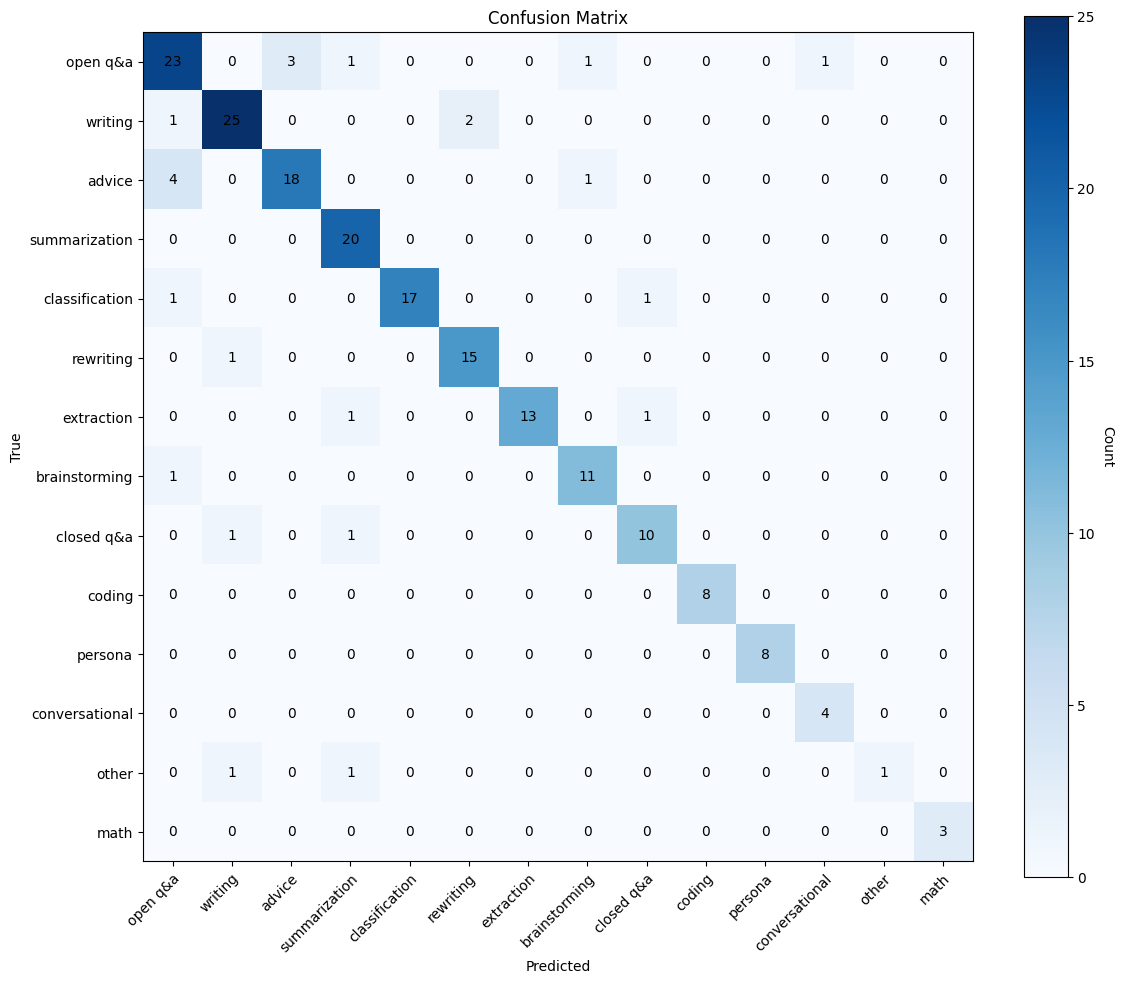

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Your confusion matrix data
confusion_matrix = np.array([
    [23,  0,  3,  1,  0,  0,  0,  1,  0,  0,  0,  1,  0,  0],
    [ 1, 25,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 4,  0, 18,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 1,  0,  0,  0, 17,  0,  0,  0,  1,  0,  0,  0,  0,  0],
    [ 0,  1,  0,  0,  0, 15,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  1,  0,  0, 13,  0,  1,  0,  0,  0,  0,  0],
    [ 1,  0,  0,  0,  0,  0,  0, 11,  0,  0,  0,  0,  0,  0],
    [ 0,  1,  0,  1,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  0,  0],
    [ 0,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3]
])

# Create labels
labels = ['open q&a', 'writing', 'advice', 'summarization', 'classification', 'rewriting', 'extraction', 'brainstorming', 'closed q&a', 'coding', 'persona', 'conversational', 'other', 'math']


counts = confusion_matrix.sum(axis=1)
label_ratio = counts / counts.sum()
domain_ratio_preference = dict(zip(labels, label_ratio))
# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the heatmap
im = ax.imshow(confusion_matrix, cmap='Blues')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Set labels
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

# Loop over data dimensions and create text annotations
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, confusion_matrix[i, j],
                       ha="center", va="center", color="black")

# Create color bar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Count", rotation=-90, va="bottom")
# Set x-axis labels
ax.set_xticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")

# Set y-axis labels
ax.set_yticklabels(labels)
# Show the plot
plt.tight_layout()
# plt.show()

In [12]:

import pandas as pd

data = {
    'Domain': [
        'open q&a', 'writing', 'advice', 'summarization', 'classification', 'rewriting',
        'extraction', 'brainstorming', 'closed q&a', 'coding', 'persona', 'conversational',
        'other', 'math'
    ],
    'Accuracy': [
        0.935, 0.97, 0.96, 0.98, 0.99, 0.985, 0.99, 0.985, 0.98, 1.0, 1.0, 0.995, 0.99, 1.0
    ],
    'Precision': [
        0.865686274509804, 0.9377076411960132, 0.9146049481245011, 0.9166666666666667,
        0.994535519125683, 0.9384442301510768, 0.9946524064171123, 0.9204031262854793,
        0.9113475177304965, 1.0, 1.0, 0.9, 0.9949748743718593, 1.0
    ],
    'Recall': [
        0.8760838878806211, 0.9377076411960132, 0.8828297715549005, 0.9888888888888889,
        0.9473684210526316, 0.9633152173913043, 0.9333333333333333, 0.9530141843971631,
        0.9113475177304965, 1.0, 1.0, 0.9974489795918368, 0.6666666666666666, 1.0
    ],
    'F1 Score': [
        0.8707689248968637, 0.9377076411960132, 0.8978549540347294, 0.9489274770173646,
        0.9694749694749695, 0.9504582610849641, 0.9615975422427036, 0.9359999999999999,
        0.9113475177304965, 1.0, 1.0, 0.9431656720659278, 0.7474747474747474, 1.0
    ],
    'AUC Score': [
        0.8760838878806211, 0.9377076411960132, 0.8828297715549005, 0.9888888888888888,
        0.9473684210526316, 0.9633152173913043, 0.9333333333333333, 0.9530141843971631,
        0.9113475177304966, 1.0, 1.0, 0.9974489795918368, 0.6666666666666666, 1.0
    ]
}

df = pd.DataFrame(data)
df

,Domain,Accuracy,Precision,Recall,F1 Score,AUC Score
0,open q&a,0.935,0.865686,0.876084,0.870769,0.876084
1,writing,0.970,0.937708,0.937708,0.937708,0.937708
2,advice,0.960,0.914605,0.882830,0.897855,0.882830
3,summarization,0.980,0.916667,0.988889,0.948927,0.988889
4,classification,0.990,0.994536,0.947368,0.969475,0.947368
5,rewriting,0.985,0.938444,0.963315,0.950458,0.963315
6,extraction,0.990,0.994652,0.933333,0.961598,0.933333
7,brainstorming,0.985,0.920403,0.953014,0.936000,0.953014
8,closed q&a,0.980,0.911348,0.911348,0.911348,0.911348
9,coding,1.000,1.000000,1.000000,1.000000,1.000000


# Understand prompt distributions

## Check prompt distribution for production

In [ ]:
domains = [x["domain"] for x in all_results]
rewards = [x["reward"] for x in all_results]


In [18]:
# for x in all_results:
#   if x["reward"] < 0.5:
#     print(x['verifications'])

all_results_new = []
for x in all_results:
  x['domain'] ='coding' if 'cod' in x['domain'] or 'help' in x['domain'] else  x['domain']
  all_results_new.append(x)

all_results = all_results_new

['open q&a', 'conversational', 'advice', 'writing', 'coding', 'rewriting', 'brainstorming', 'closed q&a', 'persona', 'math', 'summarization', 'extraction', 'other']


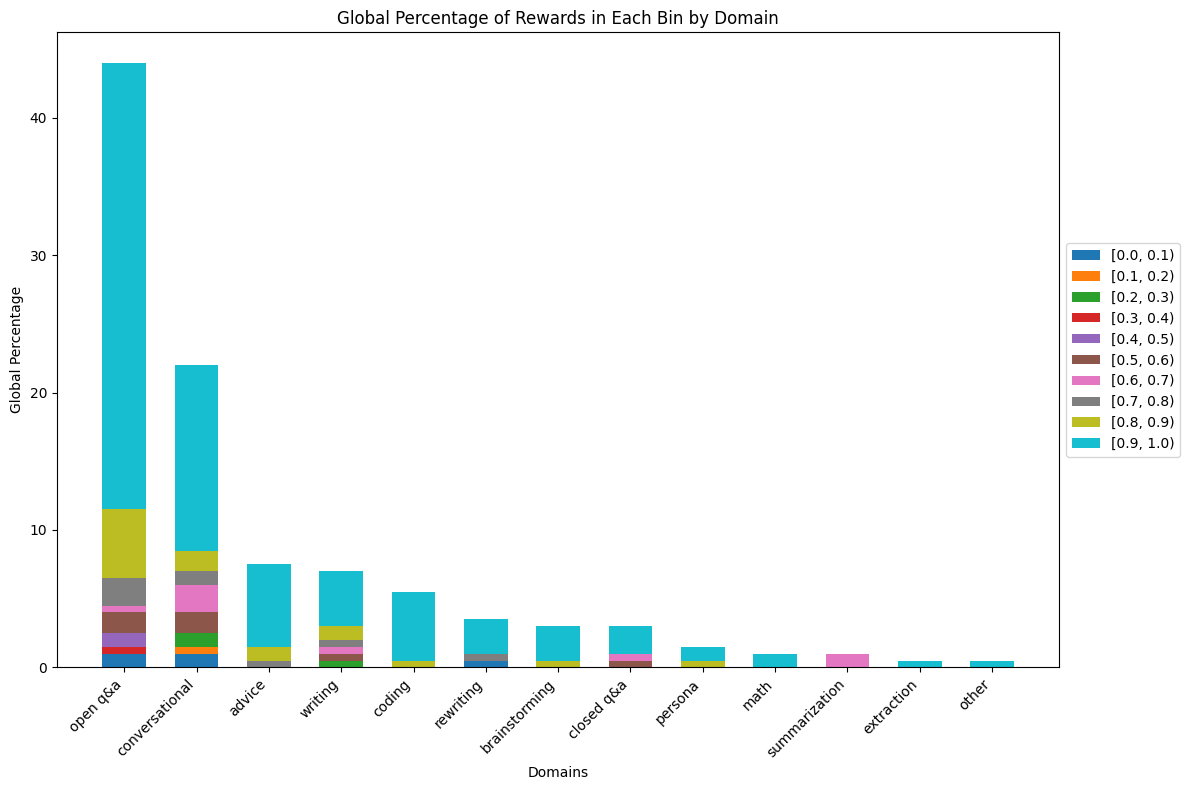

In [14]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Function to bin rewards
def bucket_rewards(reward):
    bucket_size = 0.1
    return min(int(reward / bucket_size), 9)  # Ensure rewards of 1.0 go into the last bucket

# Collect all rewards into buckets, regardless of domain
total_rewards = defaultdict(int)

for result in all_results:
    bucket = bucket_rewards(result["reward"])
    total_rewards[bucket] += 1

# Normalize counts to percentages globally
total_count = sum(total_rewards.values())
for bucket in total_rewards:
    total_rewards[bucket] = (total_rewards[bucket] / total_count) * 100

# Collect rewards into buckets for each domain
reward_distributions = defaultdict(lambda: defaultdict(int))
domain_totals = defaultdict(int)

for result in all_results:
    domain = result["domain"]
    bucket = bucket_rewards(result["reward"])
    reward_distributions[domain][bucket] += 1
    domain_totals[domain] += 1

# Normalize each domain's reward counts by the global total count
global_total = total_count
for domain in reward_distributions:
    for bucket in reward_distributions[domain]:
        reward_distributions[domain][bucket] = (reward_distributions[domain][bucket] / global_total) * 100

# Create the plot
domains = list(reward_distributions.keys())
sorted_domains = [k[0] for k in sorted(domain_totals.items(), key=lambda x: x[1], reverse=True)]
print(sorted_domains)

fig, ax = plt.subplots(figsize=(12, 8))
width = 7.8 / len(domains)  # Adjust width based on the number of domains

bottoms = [0] * len(domains)
for i, bucket in enumerate(range(10)):
    heights = [reward_distributions[domain][bucket] for domain in sorted_domains]
    ax.bar(sorted_domains, heights, width, label=f'[{bucket*0.1:.1f}, {(bucket+1)*0.1:.1f})', bottom=bottoms)
    for j, height in enumerate(heights):
        bottoms[j] += height

# Customize the plot
ax.set_xlabel('Domains')
ax.set_ylabel('Global Percentage')
ax.set_title('Global Percentage of Rewards in Each Bin by Domain')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()

In [6]:
# for x in all_results:
#   if x["reward"] < 0.5:
#     print(json.dumps(x['verifications'], indent=2))

## Check prompt distribution for SFT/XPO/RL

In [ ]:
#@title  as reference - checking sft data
import io
import pandas as pd
category_ratio = pd.read_csv(io.StringIO('''
chat,30.56%
code,34.37%
i18n,14.80%
math,16.52%
rag,1.66%
vibes,1.19%
lc,0.44%
others,0.47%
'''), header=None)
domain_names = category_ratio.to_dict()[0].values()
percentages = [float(x.replace("%", "")) for x in  category_ratio.to_dict()[1].values()]
domain_percentages = dict(zip(domain_names, percentages))


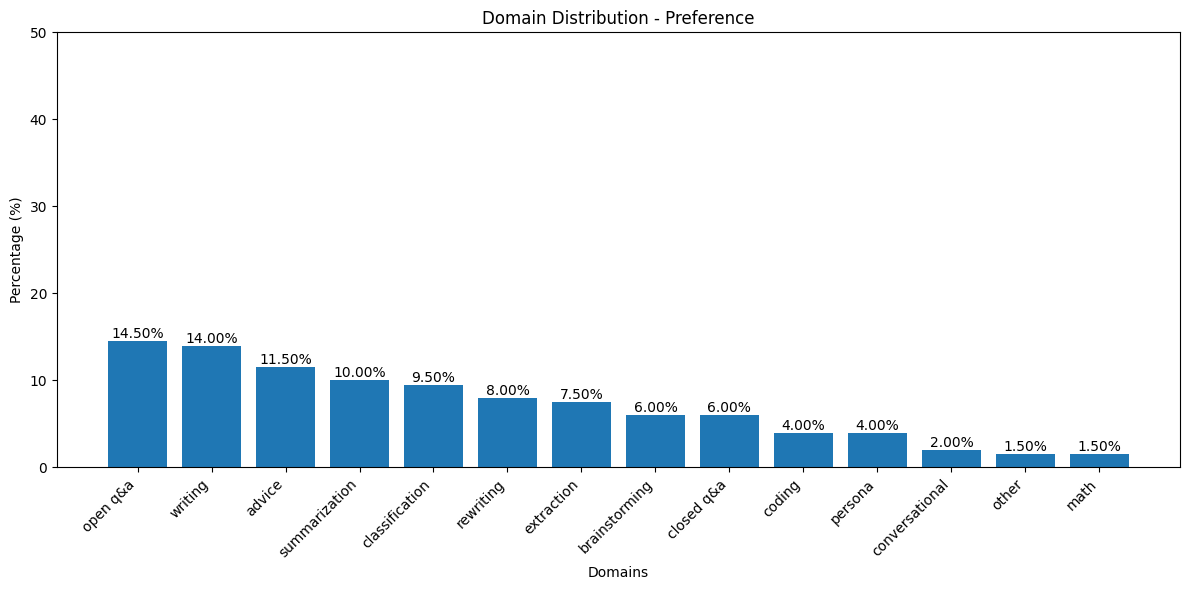

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

# Assuming all_results is your list of dictionaries containing domain information
# Example: all_results = [{"domain": "example.com"}, {"domain": "xai.com"}, ...]

# Extract and count the domains
# all_domains = [x["domain"] for x in all_results]
# domain_counts = Counter(all_domains)

# Calculate total count
# total_count = len(all_domains)

domain_percentages = dict(domain_ratio_preference)

# Sort domains by frequency and calculate percentages
sorted_domains = [k[0] for k in sorted(domain_ratio.items(), key=lambda x: x[1], reverse=True)]
percentages = [domain_percentages[d] * 100 for d in sorted_domains]

# Create the histogram
plt.figure(figsize=(12, 6))
bars = plt.bar(domain_names, percentages)

# Customize the chart
plt.title("Domain Distribution - Preference")
plt.xlabel("Domains")
plt.ylabel("Percentage (%)")
plt.ylim(0, 50)  # Ensure y-axis starts at 0 and ends at 100%

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%',
             ha='center', va='bottom')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

print(domain_ratio_preference)

open q&a: 45.50%
conversational: 24.00%
advice: 7.50%
writing: 5.50%
coding: 4.40%
rewriting: 3.10%
closed q&a: 2.30%
brainstorming: 2.20%
extraction: 1.20%
summarization: 1.20%
math: 0.90%
persona: 0.80%
classification: 0.70%
other: 0.70%


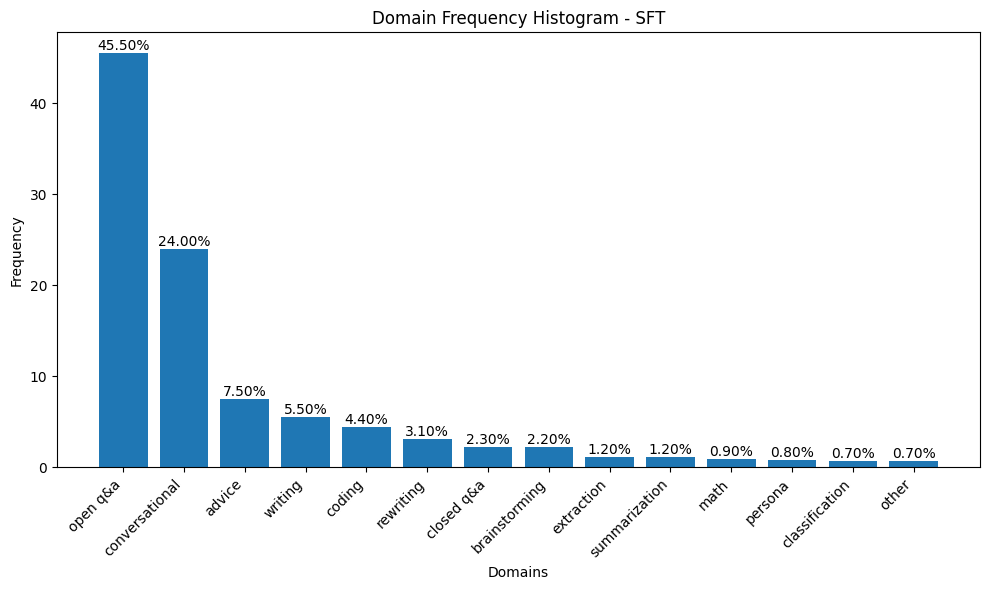

In [17]:
# @title production data
domains = {
    'open q&a': 455,
    'conversational': 240,
    'advice': 75,
    'writing': 55,
    'coding': 34 + 6+3+1,
    'rewriting': 31,
    'closed q&a': 23,
    'brainstorming': 22,
    'extraction': 12,
    'summarization': 12,
    'math': 9,
    'persona': 8,
    'classification': 7,
    'other': 7,
}

total = sum(domains.values())

domain_percentages = {domain: (count / total) * 100 for domain, count in domains.items()}
domain_names = list(domain_percentages.keys())
percentages = list(domain_percentages.values())


from collections import Counter
import matplotlib.pyplot as plt
# Create a bar chart
for domain, percentage in domain_percentages.items():
    print(f"{domain}: {percentage:.2f}%")


plt.figure(figsize=(10, 6))
bars = plt.bar(domain_names, percentages)

# Customize the chart
plt.title("Domain Frequency Histogram - SFT")
plt.xlabel("Domains")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., round(height, 2),
           f"{height:.2f}%",
             ha='center', va='bottom')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()